In [1]:
from pyxtal import Group, Wyckoff_position
from pymatgen.core import Structure, Composition
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius

import rich
import pandas as pda
import seaborn as sns
import rho_plus as rp
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

%load_ext rich

In [2]:
from baysic.utils import load_mp20
from baysic.wyckoff_span import Plane, Line, Point

df = load_mp20('train')

In [34]:
from baysic.wyckoff_span import is_nonzero
import numpy as np
spans = []
span_radii = []

sga = SpacegroupAnalyzer(row['struct'])
equiv_atoms = sga.get_symmetry_dataset()['equivalent_atoms']

symm = row['struct']
sg_num = row['sg_number']
species = symm.species
i = 0
processed = set()
for specie, symbol, equiv in zip(species, row['wyckoffs'], equiv_atoms):
    if equiv in processed:
        continue
    else:
        processed.add(equiv)

    wp = Wyckoff_position.from_group_and_letter(sg_num, symbol, style='spglib')
    if wp.get_dof() != 3:
        radius = CovalentRadius.radius[specie.symbol]
        for op in wp.ops:
            n_dof = sum(is_nonzero(op.rotation_matrix, axis=0))
            span = (Point, Line, Plane)[n_dof](op)
            did_add = False
            for span_i, prev_span in enumerate(spans):
                if span.dim == prev_span.dim and span == prev_span:
                    print(span, prev_span)
                    span_radii[span_i].append(radius)
                    did_add = True
                    break
            if not did_add:
                spans.append(span)
                span_radii.append([radius])

for span, radii in zip(spans, span_radii):
    min_dist_ratios = np.linspace(0.6, 1, 30)
    assert span.fits(symm.lattice, np.array(radii) * min_dist_ratios[0])
    prev_min = min_dist_ratios[0]
    for curr_min in min_dist_ratios[1:]:
        if not span.fits(row['lattice'], np.array(radii) * curr_min):
            break
        else:
            prev_min = curr_min

prev_min

1.0

In [4]:
import numpy as np
from pymatgen.core import Lattice

comp = Composition('Ag4C2O6')

sg = Group(115)

all_assignments = sg.list_wyckoff_combinations(list(comp.get_el_amt_dict().values()))[0]
print(len(all_assignments))
all_assignments[0]

6660


[['1d', '1c', '1b', '1a'], ['2e'], ['2e', '2e', '2e']]

In [24]:
from baysic.lattice import LATTICES, atomic_volume
from baysic.wyckoff_span import is_nonzero
from rich.progress import track

lat_model = None
for lat in LATTICES:
    if sg.number in [g.number for g in lat.get_groups()]:
        lat_model = lat(atomic_volume(comp))

print(lat_model.lattice_type)

dist_df = []
lat_matrices = [lat_model.to_lattice() for _ in range(10)]

for assignment_i, assignment in track(list(enumerate(all_assignments))):
    spans = []
    span_radii = []
    for specie, wyckoffs in zip(comp.elements, assignment):
        for wyckoff in wyckoffs:
            wp = Wyckoff_position.from_group_and_letter(sg.number, wyckoff, style='spglib')
            if wp.get_dof() != 3:
                radius = CovalentRadius.radius[specie.symbol]
                for op in wp.ops:
                    n_dof = sum(is_nonzero(op.rotation_matrix, axis=0))
                    span = (Point, Line, Plane)[n_dof](op)
                    did_add = False
                    for span_i, prev_span in enumerate(spans):
                        if span.dim == prev_span.dim and span == prev_span:
                            span_radii[span_i].append(radius)
                            did_add = True
                            break
                    if not did_add:
                        spans.append(span)
                        span_radii.append([radius])

    for lat_i, lat_matrix in enumerate(lat_matrices):
        dist_ratios = []
        for span, radii in zip(spans, span_radii):
            min_dist_ratios = np.linspace(0, 1, 100)
            prev_min = 0
            for curr_min in min_dist_ratios[1:]:
                if not span.fits(lat_matrix, np.array(radii) * curr_min):
                    dist_ratios.append(prev_min)
                    break
                else:
                    prev_min = curr_min

            if prev_min == 1:
                dist_ratios.append(prev_min)
        dist_ratio = np.min(dist_ratios)
        dist_df.append({
            'lattice': f'l_{lat_i}',
            'assignment': assignment,
            'assignment_i': assignment_i,
            'min_ratio': dist_ratio,
        })

Output()

tetragonal


In [25]:
import pandas as pd
import seaborn as sns
import rho_plus as rp
from baysic.utils import quick_view, json_to_df
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

dist_df = pd.DataFrame(dist_df)
dist_df['feasible'] = dist_df.eval('min_ratio >= 0.7')
dist_df['easy'] = dist_df.eval('min_ratio == 1')

In [26]:
dist_df.head()

,lattice,assignment,assignment_i,min_ratio,feasible,easy
0,l_0,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.353535,False,False
1,l_1,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.484848,False,False
2,l_2,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.292929,False,False
3,l_3,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.212121,False,False
4,l_4,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.515152,False,False


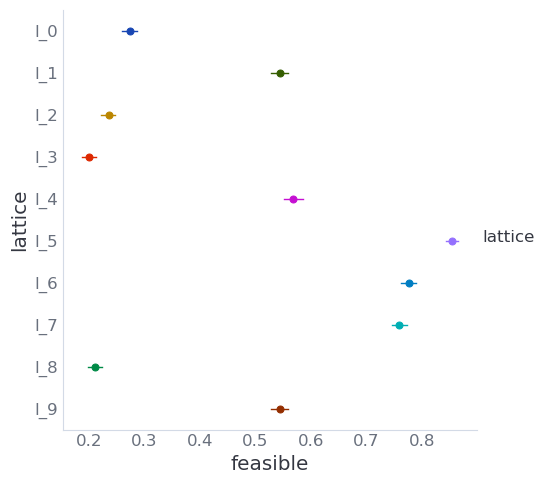

In [35]:
sns.catplot(dist_df, y='lattice', x='feasible', orient='h', kind='point', hue='lattice',
            errorbar=('ci', 99), ms=5, lw=1)

In [43]:
dist_df.groupby('assignment_i').mean(numeric_only=True)['feasible'].sort_values().head(100)


assignment_i
2736    0.0
2761    0.0
5518    0.0
5575    0.0
5619    0.0
       ... 
2580    0.1
2581    0.1
2582    0.1
686     0.1
2583    0.1
Name: feasible, Length: 100, dtype: float64